# Load libs

In [1]:
import random            
import torch
import time
import torchvision
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import pandas as pd                                 
import numpy as np
import matplotlib.pyplot as plt  
from collections import defaultdict
from datetime import timedelta
from torch.utils.data import Dataset, DataLoader

# Create abnormal dataset

In [3]:
df = pd.read_csv('../data/mnist_test.csv')
abnormal = df[:1000]
clean = df[1000:]

for i in range(len(abnormal)):
    row = abnormal.iloc[i]
    # iterate through each element in row
    for i in range(len(row)-1):
        # add noise to element
        row[i+1] = min(255, row[i+1]+random.randint(100,200))
        
abnormal['label'] = 1
clean['label'] = 0
        
test = pd.concat([abnormal, clean])  # join
test.sample(frac=1)              # shuffle
test.to_csv('../data/abnormal.csv')          # save

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


# Train autoencoder

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),

        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.ReLU(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [5]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'})
        data = torch.from_numpy(np.array(row)/255).float()
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__()
        self.dataset = pd.read_csv(
                       '../data/mnist_train.csv',
                       index_col=False
                       )

In [6]:
batch_size = 32
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
momentum = 0.9   
epochs = 15

train_set = Train_Loader()
train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            num_workers=20,
            pin_memory=True,
            drop_last=True
        )

In [8]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoEncoder()
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [9]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_set)
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.003307626290867726
Epoch Complete in 0:00:13.732139
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.00319623538206021
Epoch Complete in 0:00:14.358909
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.0030793063356230658
Epoch Complete in 0:00:13.218209
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.0029566598765552042
Epoch Complete in 0:00:13.300261
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.0028497577726840973
Epoch Complete in 0:00:13.435428
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.002768869972229004
Epoch Complete in 0:00:14.069454
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.0027195974518855414
Epoch Complete in 0:00:15.776885
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.002692624818906188
Epoch Complete in 0:00:14.009096
---------------------

# Detect anomalies

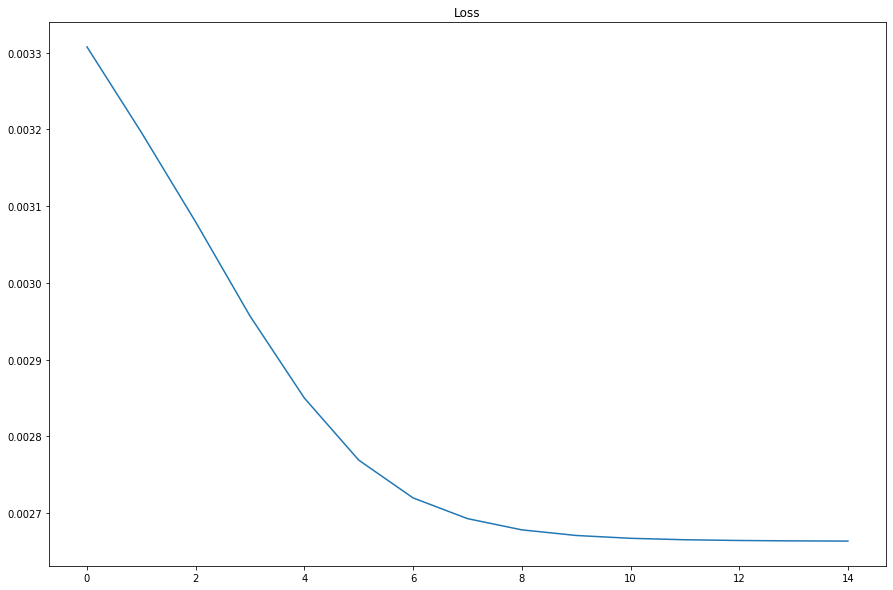

In [10]:
# train loss
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

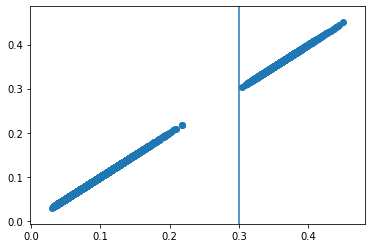

In [11]:
# Get threshold
model.eval()
loss_dist = []
anom = pd.read_csv('../data/abnormal.csv', index_col=[0])

for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())

loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)

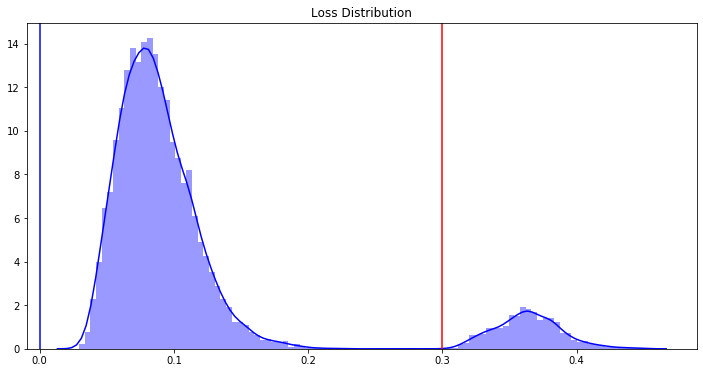

In [12]:
# Plot threshold
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

In [14]:
# Confusion matrix
df = pd.read_csv('../data/abnormal.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0


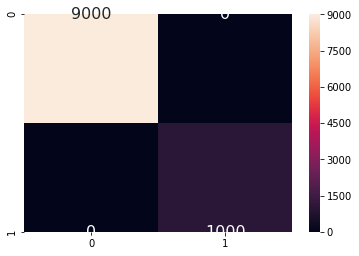

In [15]:
conf = np.array([[tn,fp],[fn,tp]])
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')